# 📊 Exploratory Data Analysis (EDA): GTSRB Dataset

**Project:** German Traffic Sign Recognition Benchmark (GTSRB)  
**Goal:** Inspect the training data, verify image paths, analyze class distribution, and validate the Region of Interest (ROI) cropping logic.

The GTSRB dataset consists of 43 classes of traffic signs. Each sample in the dataset includes:
* **Path:** The file path to the image.
* **ClassId:** The integer label (0-42) representing the sign type.
* **ROI (Region of Interest):** Bounding box coordinates (`x1`, `y1`, `x2`, `y2`) that pinpoint the traffic sign within the image.

In this notebook, we ensure the data is accessible and our preprocessing strategy (cropping) is effective.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import numpy as np
from pathlib import Path

# Configuration for plots
plt.style.use('ggplot')
%matplotlib inline

# Define paths
DATA_DIR = Path('../data/GTSRB')
CSV_PATH = DATA_DIR / 'Train.csv'

print(f"Data Directory: {DATA_DIR}")

Data Directory: ../data/GTSRB


## 1. Load Annotation Data
We load the CSV file containing the metadata for the training set. We also check the first few rows to understand the schema.

In [2]:
# Load the dataset
df = pd.read_csv(CSV_PATH)

# Display basic info
print(f"Total Training Samples: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Show the first 5 rows
df.head()

Total Training Samples: 39209
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


## 2. Class Distribution Analysis
It is crucial to check if the dataset is balanced. A highly imbalanced dataset might require techniques like weighted loss or oversampling during training.

/var/folders/jk/qxbsdvqj4zvglj6dll1p118m0000gn/T/ipykernel_71349/2737660183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ClassId', data=df, palette='viridis')


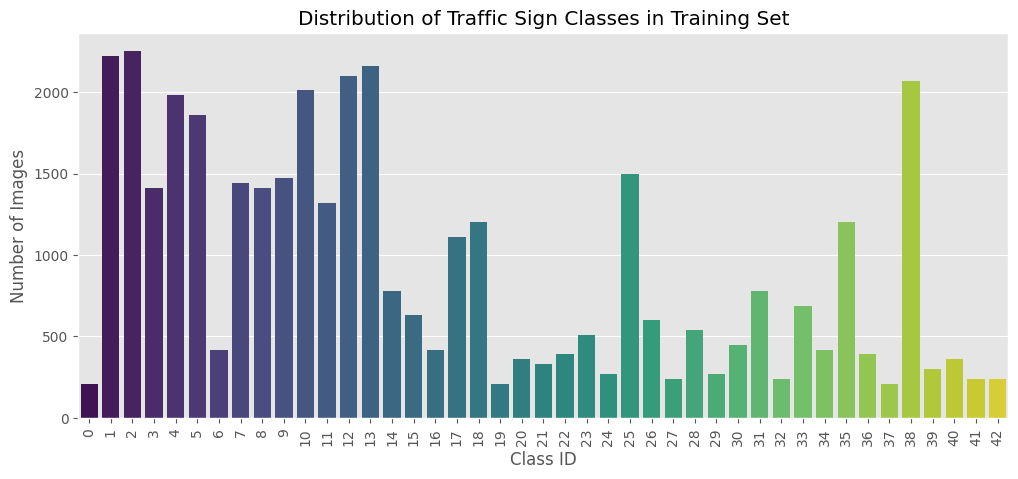

Most frequent class: 2 (2250 samples)
Least frequent class: 37 (210 samples)


In [3]:
plt.figure(figsize=(12, 5))
sns.countplot(x='ClassId', data=df, palette='viridis')
plt.title('Distribution of Traffic Sign Classes in Training Set')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# Optional: Print min and max counts
print(f"Most frequent class: {df['ClassId'].value_counts().idxmax()} ({df['ClassId'].value_counts().max()} samples)")
print(f"Least frequent class: {df['ClassId'].value_counts().idxmin()} ({df['ClassId'].value_counts().min()} samples)")

## 3. Visual Inspection & ROI Verification
The raw images often contain background noise (trees, sky, other cars). The CSV provides **ROI (Region of Interest)** coordinates to help us focus on the sign.

Below, we visualize random samples from the dataset.
* **Top Row:** The original full-size image.
* **Bottom Row:** The image cropped to the ROI coordinates.

**Hypothesis:** The cropped images should contain *only* the traffic sign, which will be the input to our Neural Network.

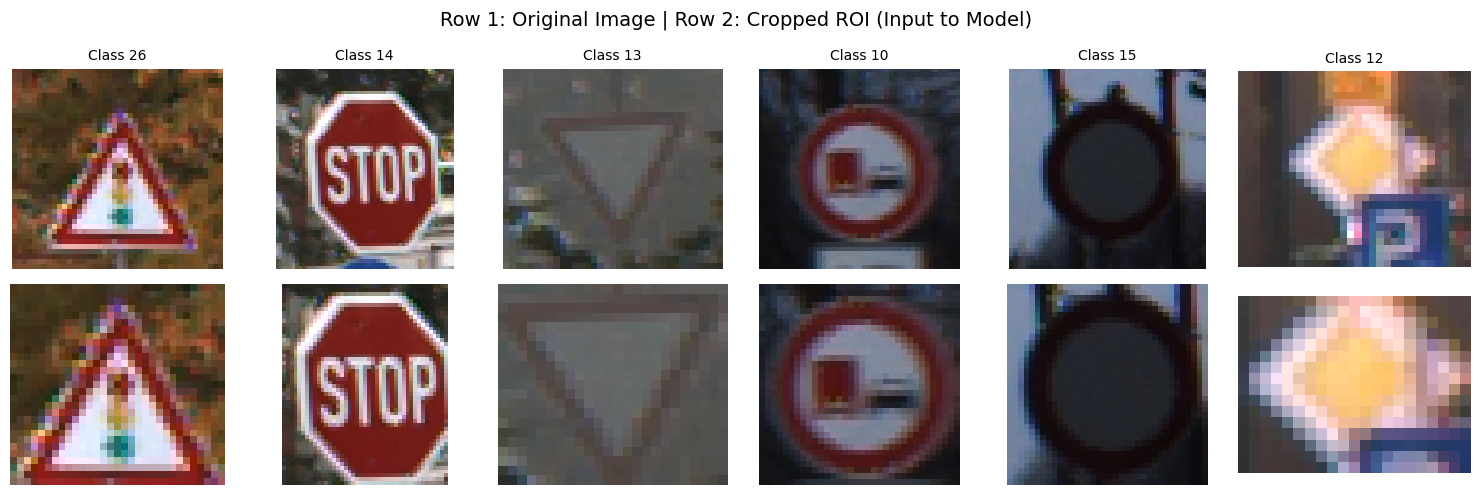

In [4]:
# Sample 6 random images
sample = df.sample(n=6, random_state=42).reset_index(drop=True)

fig, axes = plt.subplots(2, 6, figsize=(15, 5))

# Helper check for ROI columns
cols = df.columns
has_roi = {'Roi.X1','Roi.Y1','Roi.X2','Roi.Y2'}.issubset(cols)

for i, row in sample.iterrows():
    # Construct Path
    # The CSV paths might be relative, e.g., "Train/0/..." or just "0/..."
    # We join it with our base DATA_DIR
    img_path = DATA_DIR / row['Path']
    
    # Error Handling: Check if file exists
    if not img_path.exists():
        axes[0, i].text(0.5, 0.5, "File Not Found", ha='center', va='center')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        continue

    # Load Image
    img = Image.open(img_path).convert('RGB')
    
    # --- Top Row: Original ---
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Class {row['ClassId']}", fontsize=10)

    # --- Bottom Row: Cropped ROI ---
    if has_roi:
        x1 = int(row['Roi.X1'])
        y1 = int(row['Roi.Y1'])
        x2 = int(row['Roi.X2'])
        y2 = int(row['Roi.Y2'])
        
        # Defensive programming: Clip coordinates to image size
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.width, x2), min(img.height, y2)
        
        # Crop if valid
        if x2 > x1 and y2 > y1:
            cropped = img.crop((x1, y1, x2, y2))
        else:
            cropped = img # Fallback
    else:
        cropped = img

    axes[1, i].imshow(cropped)
    axes[1, i].axis('off')

plt.suptitle('Row 1: Original Image | Row 2: Cropped ROI (Input to Model)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Conclusion
* **Data Integrity:** The CSV loads correctly, and image paths match the file structure.
* **Class Imbalance:** As seen in the histogram, some classes are much more frequent than others. We should keep this in mind; however, for a robust model like ResNet, this may be manageable without heavy resampling.
* **Preprocessing:** The ROI cropping logic works as intended, successfully isolating the traffic signs from the background. We will incorporate this cropping logic into our PyTorch `Dataset` class.